# Imports

In [ ]:
!pip install geopandas

In [ ]:
!pip install geovoronoi

In [3]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.ops import cascaded_union
from geovoronoi.plotting import subplot_for_map, plot_voronoi_polys_with_points_in_area
from geovoronoi import voronoi_regions_from_coords, points_to_coords
import networkx as nx

# Import of crime data from the city of São Paulo

In [5]:
path_file = 'sample_2000.csv'
df = pd.read_csv(path_file)
df = df[['LATITUDE','LONGITUDE']]
df = df.sample(100, random_state=42)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100 entries, 567 to 1900
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   LATITUDE   100 non-null    float64
 1   LONGITUDE  100 non-null    float64
dtypes: float64(2)
memory usage: 2.3 KB


# Import shape file from São Paulo

In [6]:
boundary = gpd.read_file('DEINFO_SUBPREFEITURAS_2013.shp')

# Crime map views

In [8]:
boundary.head()

,CLASSID,FEATID,REVISIONNU,USUARIO_ID,DATA_ULT_A,USUARIO_I1,DATA_CRIAC,NOME,COD_SUBPRE,geometry
0,144.0,18.0,2.0,0.0,2013-06-23,0.0,2009-10-09,VILA PRUDENTE,29,"POLYGON ((344687.109 7387745.855, 344683.515 7..."
1,144.0,32.0,1.0,0.0,2013-06-23,0.0,2009-10-09,SAPOPEMBA,32,"POLYGON ((343449.236 7391038.677, 343452.517 7..."
2,144.0,2.0,1.0,0.0,2009-10-09,0.0,2009-10-09,FREGUESIA-BRASILANDIA,03,"POLYGON ((327514.882 7399159.242, 327494.259 7..."
3,144.0,3.0,1.0,0.0,2009-10-09,0.0,2009-10-09,CASA VERDE-CACHOEIRINHA,04,"POLYGON ((329124.990 7402389.474, 329127.571 7..."
4,144.0,4.0,1.0,0.0,2009-10-09,0.0,2009-10-09,SANTANA-TUCURUVI,05,"POLYGON ((334212.557 7398085.949, 334131.780 7..."


In [7]:
print(boundary.crs)

None


In [9]:
from shapely.geometry import Point, Polygon

geometry = [Point(xy) for xy in zip( df['LONGITUDE'], df['LATITUDE'])]
geometry[:3]
crs = {'init': 'epsg:4326'}
geo_df = gpd.GeoDataFrame(df, crs=crs, geometry=geometry)

/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [10]:
print(geo_df.crs)

+init=epsg:4326 +type=crs


In [11]:
geo_df.crs = {'init': 'epsg:4326'} 
geo_df = geo_df.to_crs({'init': 'epsg:29193'})

/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [12]:
geo_df.head()

,LATITUDE,LONGITUDE,geometry
567,-23.644796,-46.673927,POINT (329307.485 7384143.795)
99,-23.620746,-46.624528,POINT (334316.755 7386865.348)
1053,-23.617754,-46.583804,POINT (338468.365 7387243.265)
1781,-23.748055,-46.697361,POINT (327053.008 7372680.401)
1505,-23.584904,-46.635796,POINT (333121.661 7390821.322)


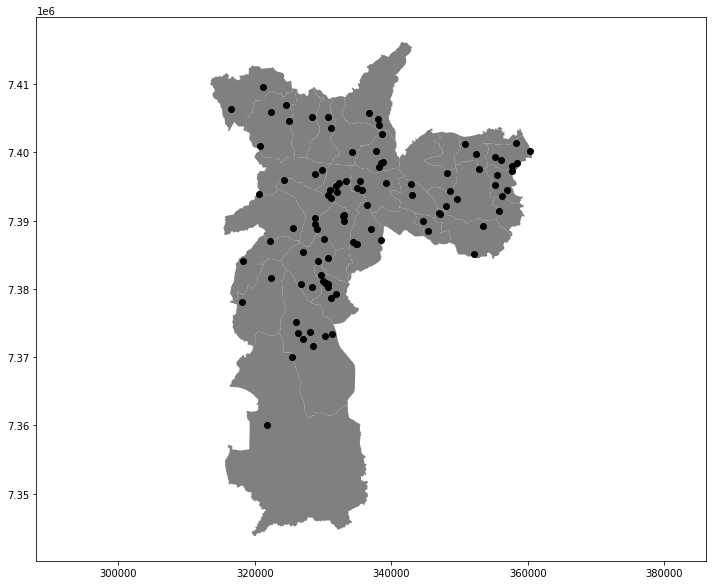

In [13]:
fig, ax = plt.subplots(figsize=(12, 10))
boundary.plot(ax=ax, color="gray")
geo_df.plot(ax=ax, color="black")
plt.axis('equal')
plt.show()

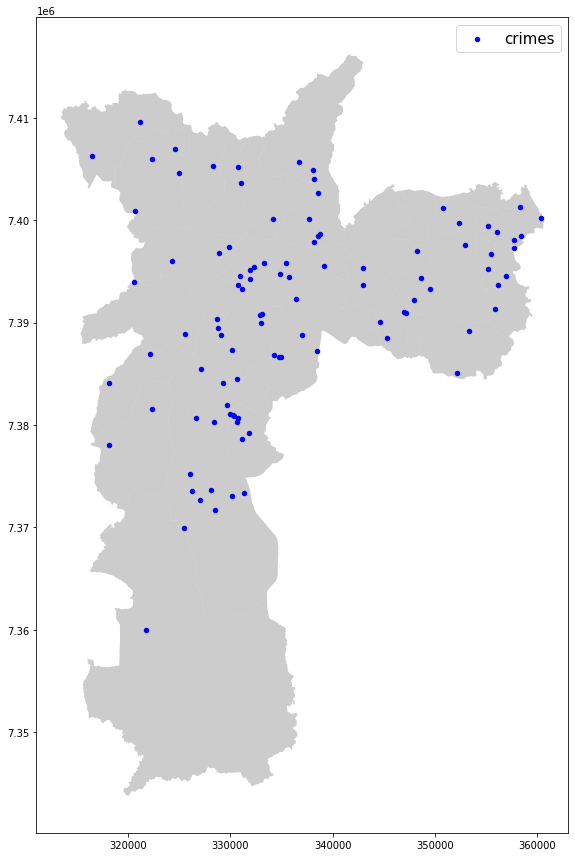

In [15]:
fig, ax = plt.subplots(figsize = (15,15))
boundary.plot(ax = ax, alpha = 0.4, color = 'grey')
geo_df.plot(ax = ax, markersize = 20, color = 'blue', marker='o',  label='crimes')
plt.legend(prop={'size':15})

# Voronoi Maps

In [16]:
boundary.crs = {'init': 'epsg:3395'} 
boundary = boundary.to_crs(epsg=3395)
gdf_proj = geo_df.to_crs(boundary.crs)

/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [17]:
boundary_shape = cascaded_union(boundary.geometry)
coords = points_to_coords(geo_df.geometry)

In [18]:
# Calculate Voronoi Regions
region_polys, region_pts = voronoi_regions_from_coords(coords, boundary_shape)

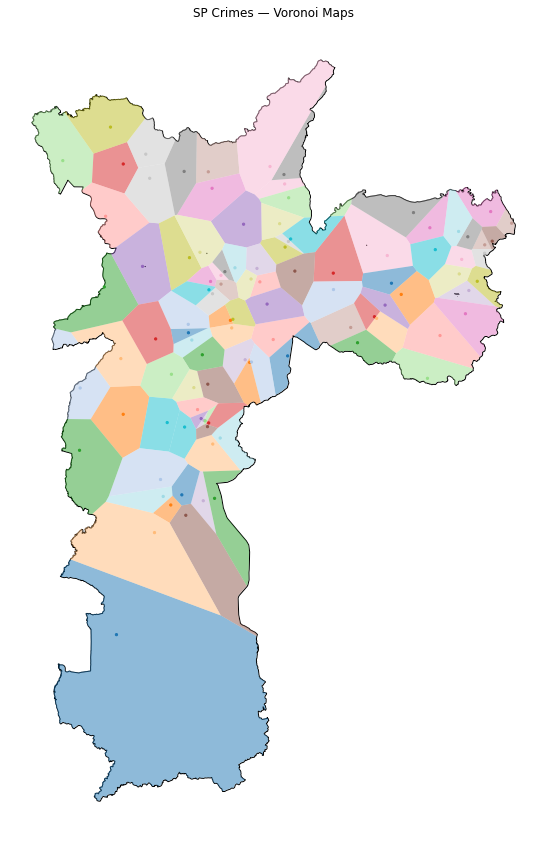

In [19]:
#Plot Voronoi Diagram
import matplotlib.pyplot as plt
from geovoronoi.plotting import subplot_for_map, plot_voronoi_polys_with_points_in_area

fig, ax = subplot_for_map(figsize = (15,15))
ax.set_title('SP Crimes — Voronoi Maps')
plot_voronoi_polys_with_points_in_area(ax, boundary_shape, region_polys, coords, region_pts)
plt.show()

# Community Detection: Label Propagation

In [20]:
# Distance matrix between crime points
matrix = geo_df.geometry.apply(lambda g: geo_df.distance(g))

In [21]:
import geopy.distance

# Converting the distance matrix to work with meters
dist = geopy.distance.geodesic(matrix.to_numpy())
dist = dist.meters

In [23]:
# New matrix: Connecting crimes with a distance less than 10000 km
new_matrix = []
for rows in dist:
  new_row = []
  for v in rows:
    if v < pow(10,7):  #10000 km
      new_row.append(1)
    else:
      new_row.append(0)
  new_matrix.append(new_row)

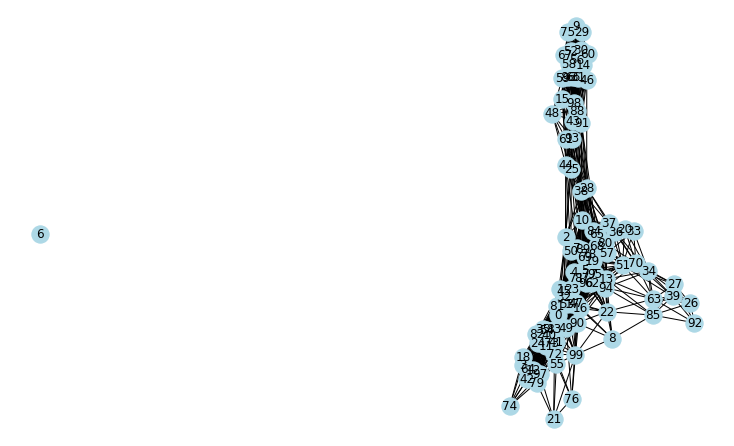

In [25]:
arr = np.array(new_matrix)
G = nx.from_numpy_matrix(arr)

pos=nx.spring_layout(G)
fig= plt.figure(figsize=(10,6))
nx.draw(G, pos=pos, node_color = 'lightblue', with_labels = True)
plt.show(True)

In [26]:
N = len(G)
M = G.number_of_edges()
print('Number of nodes:', N)
print('Number of edges:', M)

Number of nodes: 100
Number of edges: 1259


In [27]:
from networkx.algorithms import community

G = G.to_undirected()
G.remove_edges_from(nx.selfloop_edges(G))

def label_propagation_community(G):
    communities_generator = list(community.label_propagation_communities(G))
    m = []
    for i in communities_generator:
        m.append(list(i))
    return m

In [28]:
communities = label_propagation_community(G)

for cl in communities:
    print('community:', cl)

community: [2, 4, 5, 7, 10, 13, 19, 20, 22, 23, 26, 27, 28, 33, 34, 36, 37, 38, 39, 50, 51, 57, 62, 63, 65, 68, 69, 70, 71, 77, 78, 80, 84, 85, 87, 89, 92, 94, 95, 96]
community: [0, 1, 3, 8, 11, 12, 16, 17, 18, 21, 24, 32, 35, 40, 41, 42, 45, 47, 49, 53, 54, 55, 64, 72, 73, 74, 76, 79, 81, 82, 83, 90, 97, 99]
community: [9, 14, 15, 25, 29, 30, 31, 43, 44, 46, 48, 52, 56, 58, 59, 60, 61, 66, 67, 75, 86, 88, 91, 93, 98]
community: [6]


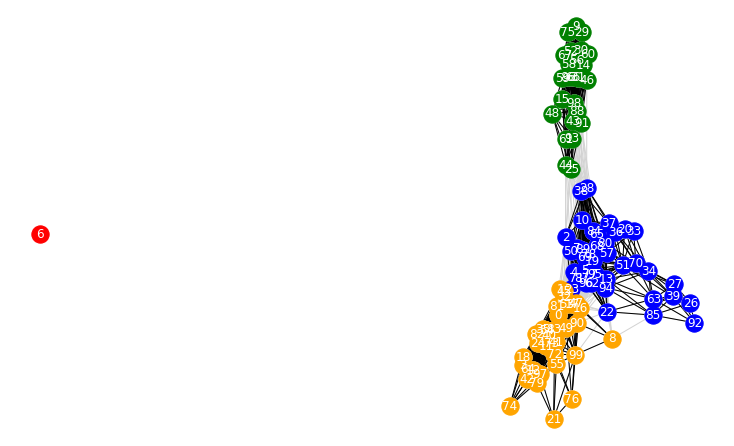

In [30]:
colors = ['blue', 'orange', 'green', 'red']

fig= plt.figure(figsize=(10,6))
nx.draw(G, pos=pos, node_color = 'white', edge_color='lightgray')
aux = 0
for cm in communities:
    nx.draw(G.subgraph(cm), pos=pos, node_color = colors[aux], 
                     with_labels = True, node_size=300, font_color = 'white')
    aux = aux + 1
plt.savefig('crime.eps') #save the figure into a file
plt.show(True)

In [32]:
count = 0
com_colors = {}
for cl in communities:
  for id in cl:
    com_colors[id] = colors[count]
  count=count+1

In [33]:
cores_voronoi = {}
for k, v in region_pts.items():
  cores_voronoi[k] = com_colors.get(v[0])

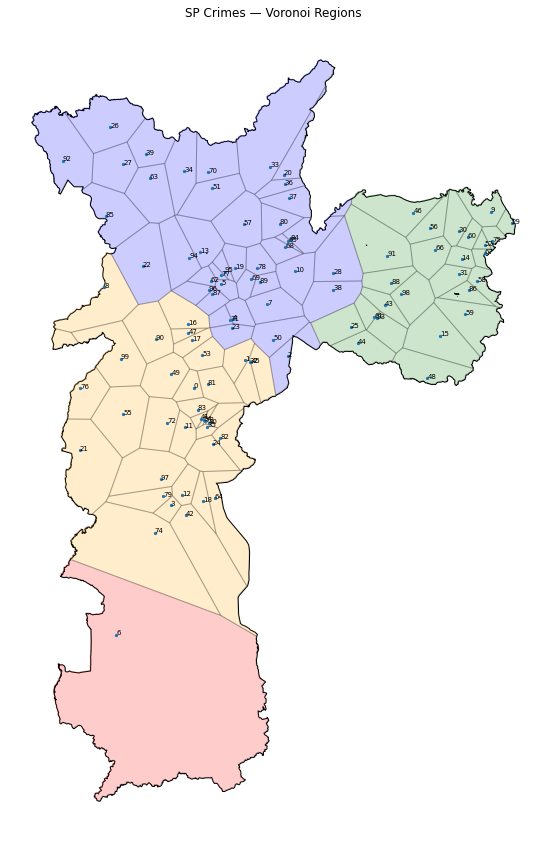

In [34]:
#Plot Voronoi Diagram
import matplotlib.pyplot as plt
from geovoronoi.plotting import subplot_for_map, plot_voronoi_polys_with_points_in_area

fig, ax = subplot_for_map(figsize = (15,15))
ax.set_title('SP Crimes — Voronoi Regions')
plot_voronoi_polys_with_points_in_area(ax, boundary_shape, region_polys,
                                       coords,
                                       plot_voronoi_opts={'alpha': 0.2},
                                       point_labels=list(map(str, range(len(coords)))),
                                       voronoi_color=cores_voronoi,
                                       voronoi_edgecolor=(0,0,0,1))
plt.show()

# Hierarchical Clustering

In [35]:
demographic_data = 'dados_demograficos.csv'
df_demographic_data = pd.read_csv(demographic_data)
df_demographic_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32 entries, 0 to 31
Data columns (total 4 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Subprefeitura                    32 non-null     object 
 1   IDH 2010                         32 non-null     float64
 2   Densidade Demográfica (Hab/km2)  32 non-null     float64
 3   Taxa média de desemprego         32 non-null     float64
dtypes: float64(3), object(1)
memory usage: 1.1+ KB


AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
                        connectivity=None, distance_threshold=None,
                        linkage='ward', memory=None, n_clusters=4)

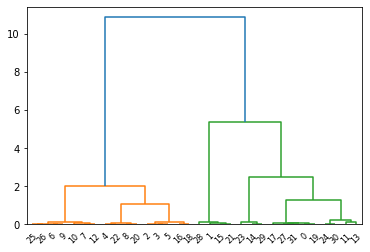

In [37]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch

X = df_demographic_data.iloc[:,[1,3]].values # IDH 2010 and Taxa média de desemprego
dendrogram = sch.dendrogram(sch.linkage(X, method='ward'))
model = AgglomerativeClustering(n_clusters=4, affinity='euclidean', linkage='ward')
model.fit(X)

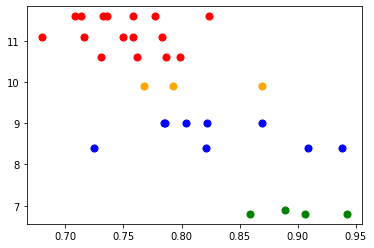

In [38]:
labels = model.labels_
plt.scatter(X[labels==0, 0], X[labels==0, 1], s=50, marker='o', color='red')
plt.scatter(X[labels==1, 0], X[labels==1, 1], s=50, marker='o', color='blue')
plt.scatter(X[labels==2, 0], X[labels==2, 1], s=50, marker='o', color='green')
plt.scatter(X[labels==3, 0], X[labels==3, 1], s=50, marker='o', color='orange')
plt.show()

In [39]:
colours = []
for label in labels:
  if label==0:
    colours.append('red')
  if label==1:
    colours.append('blue')
  if label==2:
    colours.append('green')
  if label==3:
    colours.append('orange')

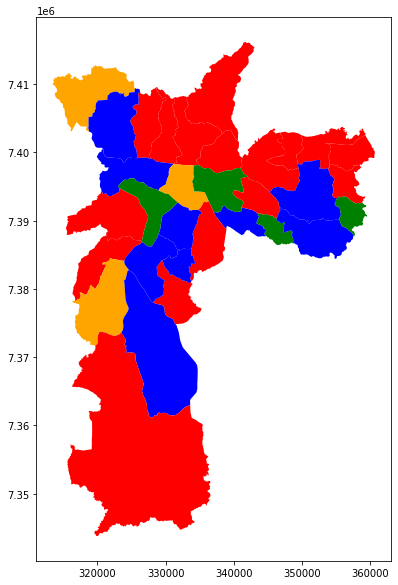

In [40]:
import random

fig, ax = plt.subplots(figsize=(12, 10))
boundary['color'] = colours
boundary.plot(ax=ax, color=boundary['color'])
plt.show()